In [94]:
%matplotlib inline

from __future__ import print_function
from statsmodels.compat import lzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [95]:
supermarket = pd.read_csv('tafeng.csv')

In [96]:
supermarket.head()

,TRANSACTION_DT,CUSTOMER_ID,AGE_GROUP,PIN_CODE,PRODUCT_SUBCLASS,PRODUCT_ID,AMOUNT,ASSET,SALES_PRICE
0,11/1/2000,1104905,45-49,115,110411,4.710200e+12,2,24,30
1,11/1/2000,418683,45-49,115,120107,4.710860e+12,1,48,46
2,11/1/2000,1057331,35-39,115,100407,4.710040e+12,2,142,166
3,11/1/2000,1849332,45-49,Others,120108,4.710130e+12,1,32,38
4,11/1/2000,1981995,50-54,115,100205,4.710180e+12,1,14,18


In [97]:
supermarket.dtypes

TRANSACTION_DT       object
CUSTOMER_ID           int64
AGE_GROUP            object
PIN_CODE             object
PRODUCT_SUBCLASS      int64
PRODUCT_ID          float64
AMOUNT                int64
ASSET                 int64
SALES_PRICE           int64
dtype: object

### Data Preprocessing

In [98]:
supermarket.PRODUCT_ID.nunique()

4930

In [99]:
supermarket.groupby('PRODUCT_ID').size().reset_index(name='count').sort_values('count', ascending=False).head()

,PRODUCT_ID,count
3743,4.710090e+12,52385
3745,4.710110e+12,31980
3738,4.710040e+12,26339
3735,4.710010e+12,19643
3739,4.710050e+12,15417


In [100]:
top_product = supermarket.loc[supermarket['PRODUCT_ID'] == 4.710090e+12]

In [101]:
top_product.shape

(52385, 9)

In [102]:
top_product.head()

,TRANSACTION_DT,CUSTOMER_ID,AGE_GROUP,PIN_CODE,PRODUCT_SUBCLASS,PRODUCT_ID,AMOUNT,ASSET,SALES_PRICE
12,11/1/2000,2116334,45-49,Others,110136,4.710090e+12,1,44,55
26,11/1/2000,841528,30-34,115,100510,4.710090e+12,2,64,94
28,11/1/2000,768566,NaN,115,110401,4.710090e+12,1,40,55
35,11/1/2000,539166,40-44,115,130103,4.710090e+12,1,15,19
37,11/1/2000,1849332,45-49,Others,110411,4.710090e+12,2,40,37


In [103]:
top_product['TRANSACTION_DT'] = pd.to_datetime(top_product['TRANSACTION_DT'])

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [104]:
top_product = top_product.groupby('TRANSACTION_DT').agg({'AMOUNT':'sum', 'ASSET':'mean', 'SALES_PRICE':'mean'})

In [105]:
top_product.head(10)

,AMOUNT,ASSET,SALES_PRICE
TRANSACTION_DT,,,
2000-11-01,292,58.900000,64.470588
2000-11-02,1432,82.413619,89.590164
2000-11-03,1601,117.044665,126.621588
2000-11-04,895,66.413011,76.712557
2000-11-05,1350,66.462857,77.456190
2000-11-06,664,73.872951,86.418033
2000-11-07,596,73.244656,86.600950
2000-11-08,371,63.936803,76.107807
2000-11-09,524,70.194175,83.436893


## Regression Analysis

### Ordinary Least Squares (OLS) Estimation

In [106]:
supermarket_model = ols("AMOUNT ~ ASSET + SALES_PRICE", data=top_product).fit()

In [107]:
print(supermarket_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 AMOUNT   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     4.970
Date:                Fri, 31 Aug 2018   Prob (F-statistic):            0.00848
Time:                        13:11:14   Log-Likelihood:                -871.25
No. Observations:                 120   AIC:                             1749.
Df Residuals:                     117   BIC:                             1757.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     474.8755    268.047      1.772      

The small P values indicate that we can reject the null hypothesis that ASSET and SALES PRICE have no effect on AMOUNT.

In regression analysis, we'd like our regression model to have a combination of high r squared and low P value, which indicates that changes in the predictors (SALES_PRICE and ASSET) are related to changes in the response variable (AMOUNT) and that our model explains a lot of the response variability. But our regression model has relative significant variables but explains little of the variability. It has low P values and a low R-squared.

Since it’s difficult to understand this situation using numbers alone. We show graphs and try to correctly interpret regression analysis results.

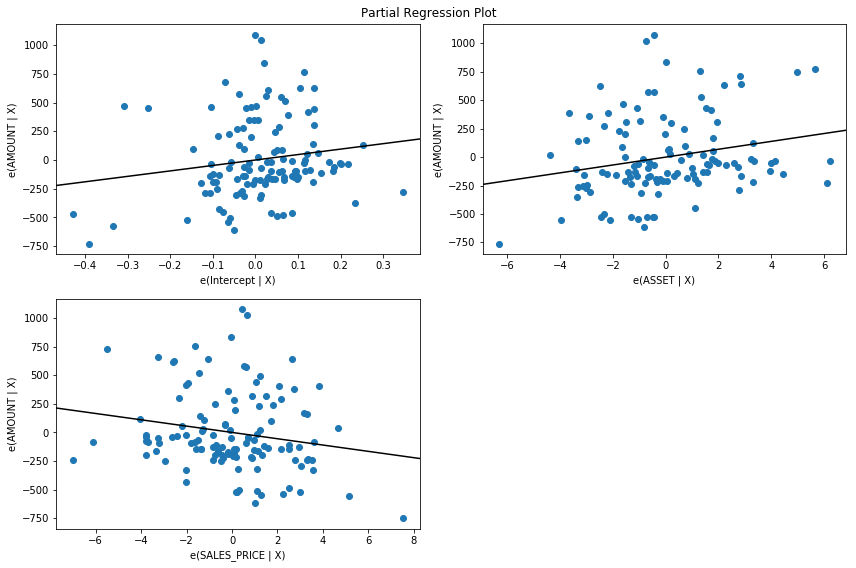

In [108]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(supermarket_model, fig=fig)

The graphs show that even noisy, high-variability data can have a significant trend. The trend indicates that the predictor variables (ASSET and SALES PRICE) still provide information about the response (AMOUNT) even though data points fall further from the regression line. However, the predictions are not very precise given a prediction interval that extends from about -56 to 1006.

### Component-Component plus Residual (CCPR) Plots

The CCPR plot provides a way to judge the effect of one regressor on the response variable by taking into account the effects of the other independent variables.

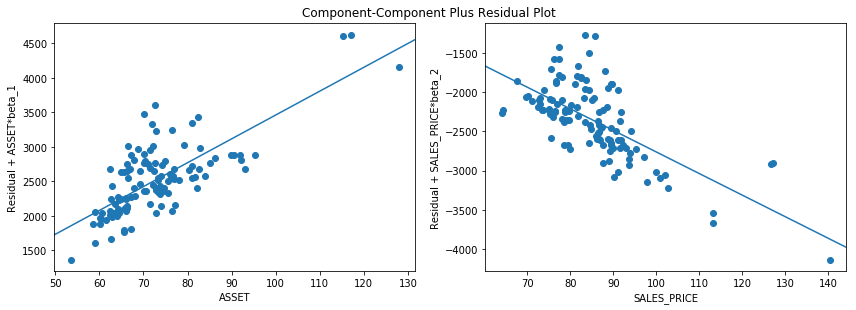

In [109]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(supermarket_model, fig=fig)

As you can see the relationship between the variation in AMOUNT explained by ASSET conditional on SALES PRICE seems to be linear, and the relationship between the variation in AMOUNT explained by SALES PRICE conditional on ASSET seems to be linear as well, though there are some observations that are exerting considerable influence on the relationships.

### Regression plots

We use plot_regress_exog function to quickly check model assumptions with respect to a single regressor, SALES PRICE in this case. 

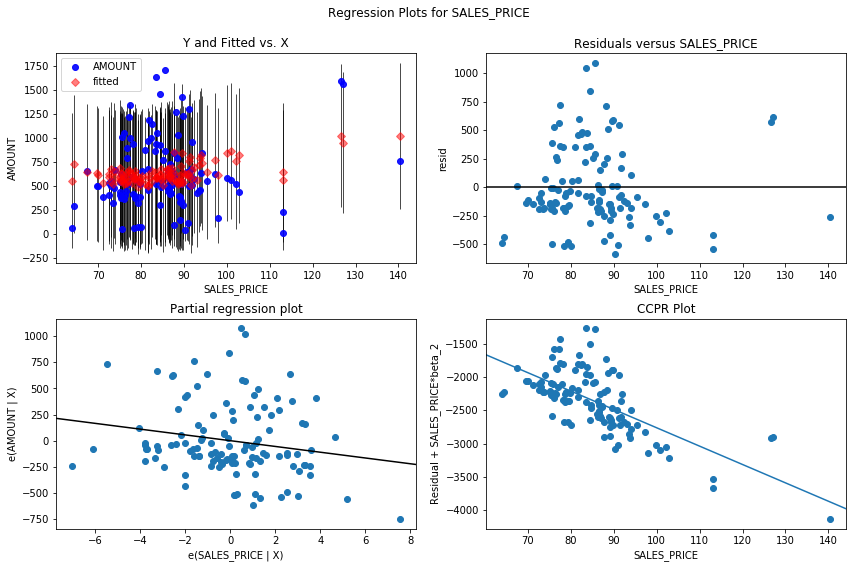

In [110]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(supermarket_model, "SALES_PRICE", fig=fig)

### Recursive Least Square (RLS)

Finally we apply Recursive Least Square (RLS) filter to investigate parameter instability.

In [114]:
endog = top_product['AMOUNT']

# To the regressors in the dataset, we add a column of ones for an intercept
exog = sm.add_constant(top_product[['ASSET', 'SALES_PRICE']])

### RLS estimation

In [115]:
mod = sm.RecursiveLS(endog, exog)
res = mod.fit()

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                 AMOUNT   No. Observations:                  120
Model:                    RecursiveLS   Log Likelihood                -859.991
Date:                Fri, 31 Aug 2018   AIC                           1725.983
Time:                        14:48:19   BIC                           1734.345
Sample:                    11-01-2000   HQIC                          1729.379
                         - 02-28-2001                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         474.8419    265.439      1.789      0.074     -45.410     995.093
ASSET          34.5936     13.711      2.523      0.012       7.721      61.466
SALES_PRICE   -27.6232     13.362     -2.067    

The RLS model computes the regression parameters recursively, so there are as many estimates as there are datapoints, the summary table only presents the regression parameters estimated on the entire sample; these estimates are equivalent to OLS estimates.

### RLS plots

We can generate the recursively estimated coefficients plot on a given variable.

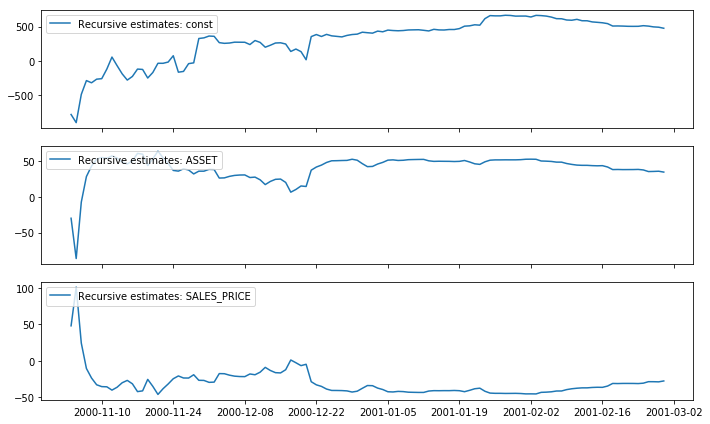

In [116]:
res.plot_recursive_coefficient(range(mod.k_exog), alpha=None, figsize=(10,6));

For convenience, we visually check for parameter stability using the plot_cusum function.

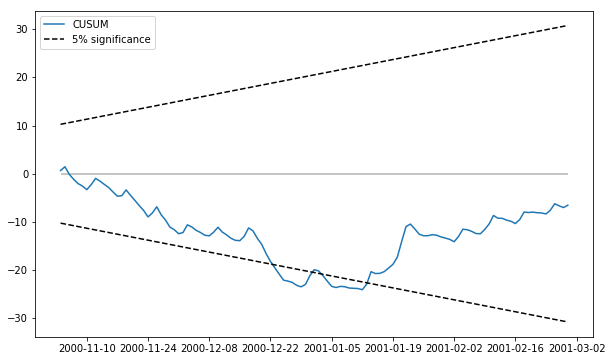

In [121]:
fig = res.plot_cusum(figsize=(10,6));

In the plot above, the CUSUM statistic does move outside of the 5% significance bands, so we reject the null hypothesis of stable parameters at the 5% level.

The good news is that even when R-squared is low, low P values still indicate a real relationship between the significant predictors and the response variable.